In [1]:
import pickle
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
from xgboost import XGBRegressor
from sklearn.base import RegressorMixin

class PatchedXGB(XGBRegressor, RegressorMixin):
    # borrow tags from a fresh instance
    __sklearn_tags__ = XGBRegressor().__sklearn_tags__  

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ─── 1) Load & parse raw data (no deprecated parser!) ─────────────────────────
raw = pd.read_csv(
    "California_airquality.csv",
    encoding="ISO-8859-1",
    usecols=[
        "Date","Source","Site ID","POC","UNITS","DAILY_AQI_VALUE","Site Name",
        "DAILY_OBS_COUNT","PERCENT_COMPLETE","AQS_PARAMETER_CODE","AQS_PARAMETER_DESC",
        "CBSA_CODE","CBSA_NAME","STATE_CODE","STATE","COUNTY_CODE","COUNTY",
        "SITE_LATITUDE","SITE_LONGITUDE","Daily Mean PM2.5 Concentration"
    ],
    parse_dates=["Date"],         # let pandas infer automatically
)
# Force a clean YYYY-MM-DD (strip any stray tz)
raw["Date"] = pd.to_datetime(raw["Date"].dt.strftime("%Y-%m-%d"))


/var/folders/ch/501q6vqd6s10pmgmd7ytk7ph0000gp/T/ipykernel_48875/2333046327.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw = pd.read_csv(


In [3]:
# ─── 2) Rename columns to snake_case (ref. image 2) ──────────────────────────────
rename_map = {
    "Date":               "date",
    "Source":             "source",
    "Site ID":            "site_id",
    "POC":                "poc",
    "UNITS":              "units",
    "DAILY_AQI_VALUE":    "daily_aqi_value",
    "Site Name":          "site_name",
    "DAILY_OBS_COUNT":    "daily_obs_count",
    "PERCENT_COMPLETE":   "percent_complete",
    "AQS_PARAMETER_CODE": "aqs_parameter_code",
    "AQS_PARAMETER_DESC": "aqs_parameter_desc",
    "CBSA_CODE":          "cbsa_code",
    "CBSA_NAME":          "cbsa_name",
    "STATE_CODE":         "state_code",
    "STATE":              "state",
    "COUNTY_CODE":        "county_code",
    "COUNTY":             "county",
    "SITE_LATITUDE":      "site_latitude",
    "SITE_LONGITUDE":     "site_longitude",
    "Daily Mean PM2.5 Concentration": "pm25"
}
df = raw.rename(columns=rename_map)


In [4]:
# 3) Filter to PM2.5 only
df = df[df["aqs_parameter_code"] == 88101].copy()

In [5]:
# 4) Build date features
df["month"]      = df["date"].dt.month
df["year"]       = df["date"].dt.year
df["month_name"] = df["date"].dt.month_name()
df["weekday"]    = df["date"].dt.day_name()

In [6]:
# 5) Add season features
def get_season(m):
    if m in (12,1,2):  return "winter"
    if m in (3,4,5):   return "spring"
    if m in (6,7,8):   return "summer"
    return "fall"

df["season"] = df["month"].apply(get_season)
df = pd.get_dummies(df, columns=["season"], drop_first=True)

In [7]:
# 6) Add lag features
df["pm25_lag1"]    = df["pm25"].shift(1)
df["pm25_7d_avg"]  = df["pm25"].rolling(7, min_periods=1).mean()


In [8]:
# 7) Build target column
df["pm25_tomorrow"] = df["pm25"].shift(-1)
df = df.drop(columns=["date"])
df = df.dropna()   # drops first row (lag1 NaN) and last row (target NaN)

print(f"✅ Final shape: {df.shape}  (rows, features including target)")


✅ Final shape: (19160, 29)  (rows, features including target)


In [9]:
# ─── 8) Baseline check: persistence model ────────────────────────────────────────
y_true = df["pm25_tomorrow"].values
y_base = df["pm25_lag1"].values
rmse_base = np.sqrt(mean_squared_error(y_true, y_base))
r2_base   = r2_score(y_true, y_base)
print(f"Baseline (tomorrow=today) →  RMSE: {rmse_base:.2f},  R²: {r2_base:.3f}")

Baseline (tomorrow=today) →  RMSE: 10.43,  R²: 0.198


In [10]:
# ─── 9) Cyclical month encoding & drop originals ─────────────────────────────────
df["month_sin"] = np.sin(2*np.pi * df["month"]/12)
df["month_cos"] = np.cos(2*np.pi * df["month"]/12)
df = df.drop(columns=["month","month_name","weekday","site_name","aqs_parameter_desc"])


In [11]:
# ─── 10) Prepare training data ─────────────────────────────────────────────────
X = df.drop(columns=["pm25_tomorrow"])
X = pd.get_dummies(
    X,
    columns=["source","units","state","county","cbsa_name"],
    drop_first=True,
    dtype=float
)
y = df["pm25_tomorrow"]

In [12]:
tscv = TimeSeriesSplit(n_splits=5)
xgb  = XGBRegressor(objective="reg:squarederror", random_state=42)

param_dist = {
    "n_estimators":     [100, 200, 300],
    "learning_rate":    [0.01, 0.05, 0.1],
    "max_depth":        [3, 5, 7],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}


search = RandomizedSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X, y)
best = search.best_estimator_
print("🔑 Best params:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔑 Best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [13]:
# ───12) Final-fold evaluation ──────────────────────────────────────────────────
_, test_idx = list(tscv.split(X))[-1]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]


y_pred      = best.predict(X_test)
rmse_imp    = np.sqrt(mean_squared_error(y_test, y_pred))
r2_imp      = r2_score(y_test, y_pred)
print(f"Improved model → RMSE: {rmse_imp:.2f}, R²: {r2_imp:.3f}")

Improved model → RMSE: 6.24, R²: 0.779


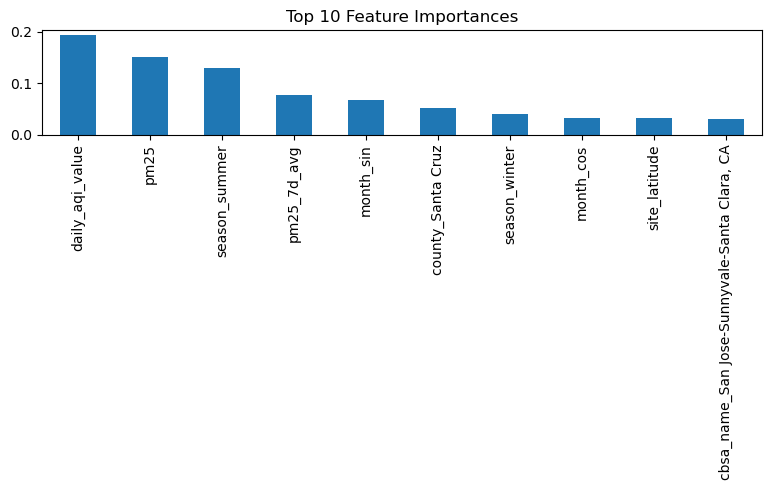

In [14]:
# ───13) Plot top-10 feature importances ────────────────────────────────────────
fi = pd.Series(best.feature_importances_, index=X.columns)
fi.sort_values(ascending=False).head(10).plot.bar(figsize=(8,5))
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


In [17]:


def predict_pm25_tomorrow(observation):
    """
    Given a single observation (dict or single-row DataFrame) with the same features
    you used in training (e.g. pm25, pm25_lag1, pm25_7d_avg, month_sin, month_cos, 
    season_spring, season_summer, season_winter, plus any encoded categoricals),
    this function:
    
      1. Loads the trained XGBoost model & preprocessor
      2. Preprocesses the observation
      3. Returns the predicted PM2.5 for tomorrow
      4. Shows a SHAP waterfall plot breaking down that single prediction
    """
    # 1) Load model + preprocessor
    with open("xgboost_best_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("preprocessor.pkl", "rb") as f:
        preprocessor = pickle.load(f)
        
        # ─── Function definition ──────────────────────────────────────────
def predict_pm25_tomorrow(observation):
    # 1) Load model + preprocessor
    with open("xgboost_best_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("preprocessor.pkl", "rb") as f:
        preprocessor = pickle.load(f)


    # 2) Convert dict → DataFrame if needed
    if isinstance(observation, dict):
        obs_df = pd.DataFrame([observation])
    else:
        obs_df = observation.copy()  # assume it's already a 1-row DataFrame

    # 3) Preprocess (this applies your scalers / one-hot / cyclical transforms, etc)
    X_proc = preprocessor.transform(obs_df)
    X_proc = pd.DataFrame(X_proc, columns=model.feature_names_in_)

    # 4) Predict
    pred = model.predict(X_proc)[0]
    print(f"🔮 Predicted PM2.5 for tomorrow: {pred:.2f} µg/m³")

    # 5) Explain with SHAP
    explainer  = shap.Explainer(model)
    shap_vals  = explainer(X_proc)
    shap.waterfall_plot(shap_vals[0])
    plt.show()

    return pred


🔮 Predicted PM2.5 for tomorrow: 4.57 µg/m³


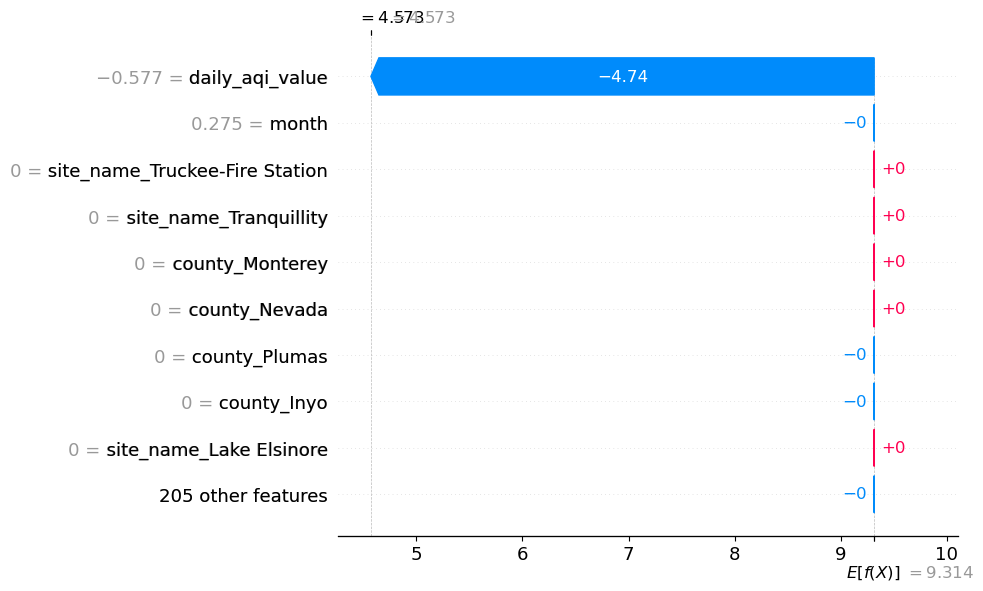

Predicted PM2.5 tomorrow: 4.57 µg/m³


In [20]:
# ─── Example usage: Predict tomorrow’s PM2.5 for a single day ─────────────────

# 1) Compose your “observation” dict with the same training-time features
new_obs = {
    # exactly the snake_case names in preprocessor.feature_names_in_
    "source":             "AQS",
    "site_id":            60010007,
    "poc":                3,
    "units":              "ug/m3 LC",
    "daily_aqi_value":    19,
    "site_name":          "Livermore",
    "daily_obs_count":    1,
    "percent_complete":   100,
    "aqs_parameter_code": 88101,
    "aqs_parameter_desc": "PM2.5 - Local Conditions",
    "cbsa_code":          44740,
    "cbsa_name":          "Livermore",
    "state_code":         6,
    "state":              "CA",
    "county_code":        1,
    "county":             "Alameda",
    "site_latitude":      37.68,
    "site_longitude":     -121.768,
    # plus the renamed 'pm25' column (was "Daily Mean PM2.5 Concentration")
    "pm25":               14.2,
    # And the date parts if your transformer needs them (you dropped date, but it built month/year/week…)
    "month":              5,
    "year":               2025,
    "month_name":         "May",
    "weekday":            "Wednesday"
}
predicted_pm25 = predict_pm25_tomorrow(new_obs)


# 3) Print it (the function already prints and shows SHAP)
print(f"Predicted PM2.5 tomorrow: {predicted_pm25:.2f} µg/m³")
